In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE

In [2]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

-----
anndata     0.7.5
scanpy      1.6.0
sinfo       0.3.1
-----
MulticoreTSNE       NA
PIL                 7.0.0
anndata             0.7.5
appnope             0.1.0
backcall            0.1.0
cffi                1.14.0
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.1
get_version         2.1
google              NA
h5py                2.10.0
importlib_metadata  1.6.1
ipykernel           5.3.0
ipython_genutils    0.2.0
jedi                0.13.3
joblib              0.14.1
kiwisolver          1.1.0
legacy_api_wrap     1.2
llvmlite            0.34.0
loompy              3.0.6
matplotlib          3.1.2
mpl_toolkits        NA
natsort             7.1.0
numba               0.51.2
numexpr             2.7.1
numpy               1.18.1
numpy_groupies      0.9.13
packaging           20.4
pandas              1.0.5
parso               0.4.0
pexpect             4.7.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit      2.0.9
ptyproces

In [3]:
sc.settings.njobs = 20

## Expression Data Import

Will be using 10x Genomics mtx files. Similar to Seurat Read10x

In [4]:
test_dir = '/Volumes/HOSSAM/Lab-Data/test'

adata = sc.read_10x_mtx(test_dir, var_names='gene_symbols')

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [5]:
row_attrs = { 
    "Gene": np.array(adata.var.index) ,
}
col_attrs = { 
    "CellID":  np.array(adata.obs.index) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}

lp.create( 'test.loom', adata.X.transpose(), row_attrs, col_attrs )

In [6]:
row_attrs

{'Gene': array(['LOC105439897', 'LOC105436482', 'LOC764781', ..., 'trnag-ucc-32',
        'LOC582726', 'LOC100893868'], dtype=object)}

In [7]:
col_attrs

{'CellID': array(['AAACGCTGTGTACATC-1', 'AAACGCTTCCAGTGTA-1', 'AAAGGATGTTTACGTG-1',
        'AAAGGTATCAGGAAAT-1', 'AAAGTCCAGCTCGAAG-1', 'AAATGGAAGTGATAAC-1',
        'AACAAAGCAAATACGA-1', 'AACAACCAGTATGCAA-1', 'AACAAGACACTTGTGA-1',
        'AACACACAGTGCAACG-1', 'AACACACTCAGACATC-1', 'AACAGGGAGCTAGCCC-1',
        'AACAGGGCACACAGCC-1', 'AACCAACGTGAGATTA-1', 'AACCCAACATGACACT-1',
        'AACCCAAGTCGTACAT-1', 'AACCTGACACTATCGA-1', 'AACGAAAGTTGTCTAG-1',
        'AACGTCAAGGGATCTG-1', 'AACGTCACATGGGTTT-1', 'AACGTCATCGCTGACG-1',
        'AACTTCTAGGAATCGC-1', 'AACTTCTCATACACCA-1', 'AACTTCTGTGAATGTA-1',
        'AAGAACAAGCGGATCA-1', 'AAGACAATCCGATCTC-1', 'AAGACAATCTGCTCTG-1',
        'AAGACTCCAGAGGTAC-1', 'AAGATAGAGCAAGCCA-1', 'AAGATAGTCCTGATAG-1',
        'AAGCATCAGGCTCTAT-1', 'AAGCCATGTACAAAGT-1', 'AAGCGTTCAACCAGAG-1',
        'AAGCGTTCACCCTTGT-1', 'AAGGAATGTGACCTGC-1', 'AAGGTAAAGTAGGCCA-1',
        'AAGTACCTCCCACAGG-1', 'AAGTCGTGTCGACTGC-1', 'AAGTGAACACGCGTCA-1',
        'AAGTGAATCCGGTAAT-1'

## Basic Filtering

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
adata = sc.read_loom( 'test.loom' )

In [10]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0.0  -  157943.0
Number of cells in which each gene is detected: 0  -  950


In [11]:
adata

AnnData object with n_obs × n_vars = 950 × 32262
    obs: 'nGene', 'nUMI'

In [12]:
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)

minCountsPerGene:  28.5
minSamples:  9.5


In [13]:
# simply compute the number of genes per cell (computers 'n_genes' column)
sc.pp.filter_cells(adata, min_genes=0)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

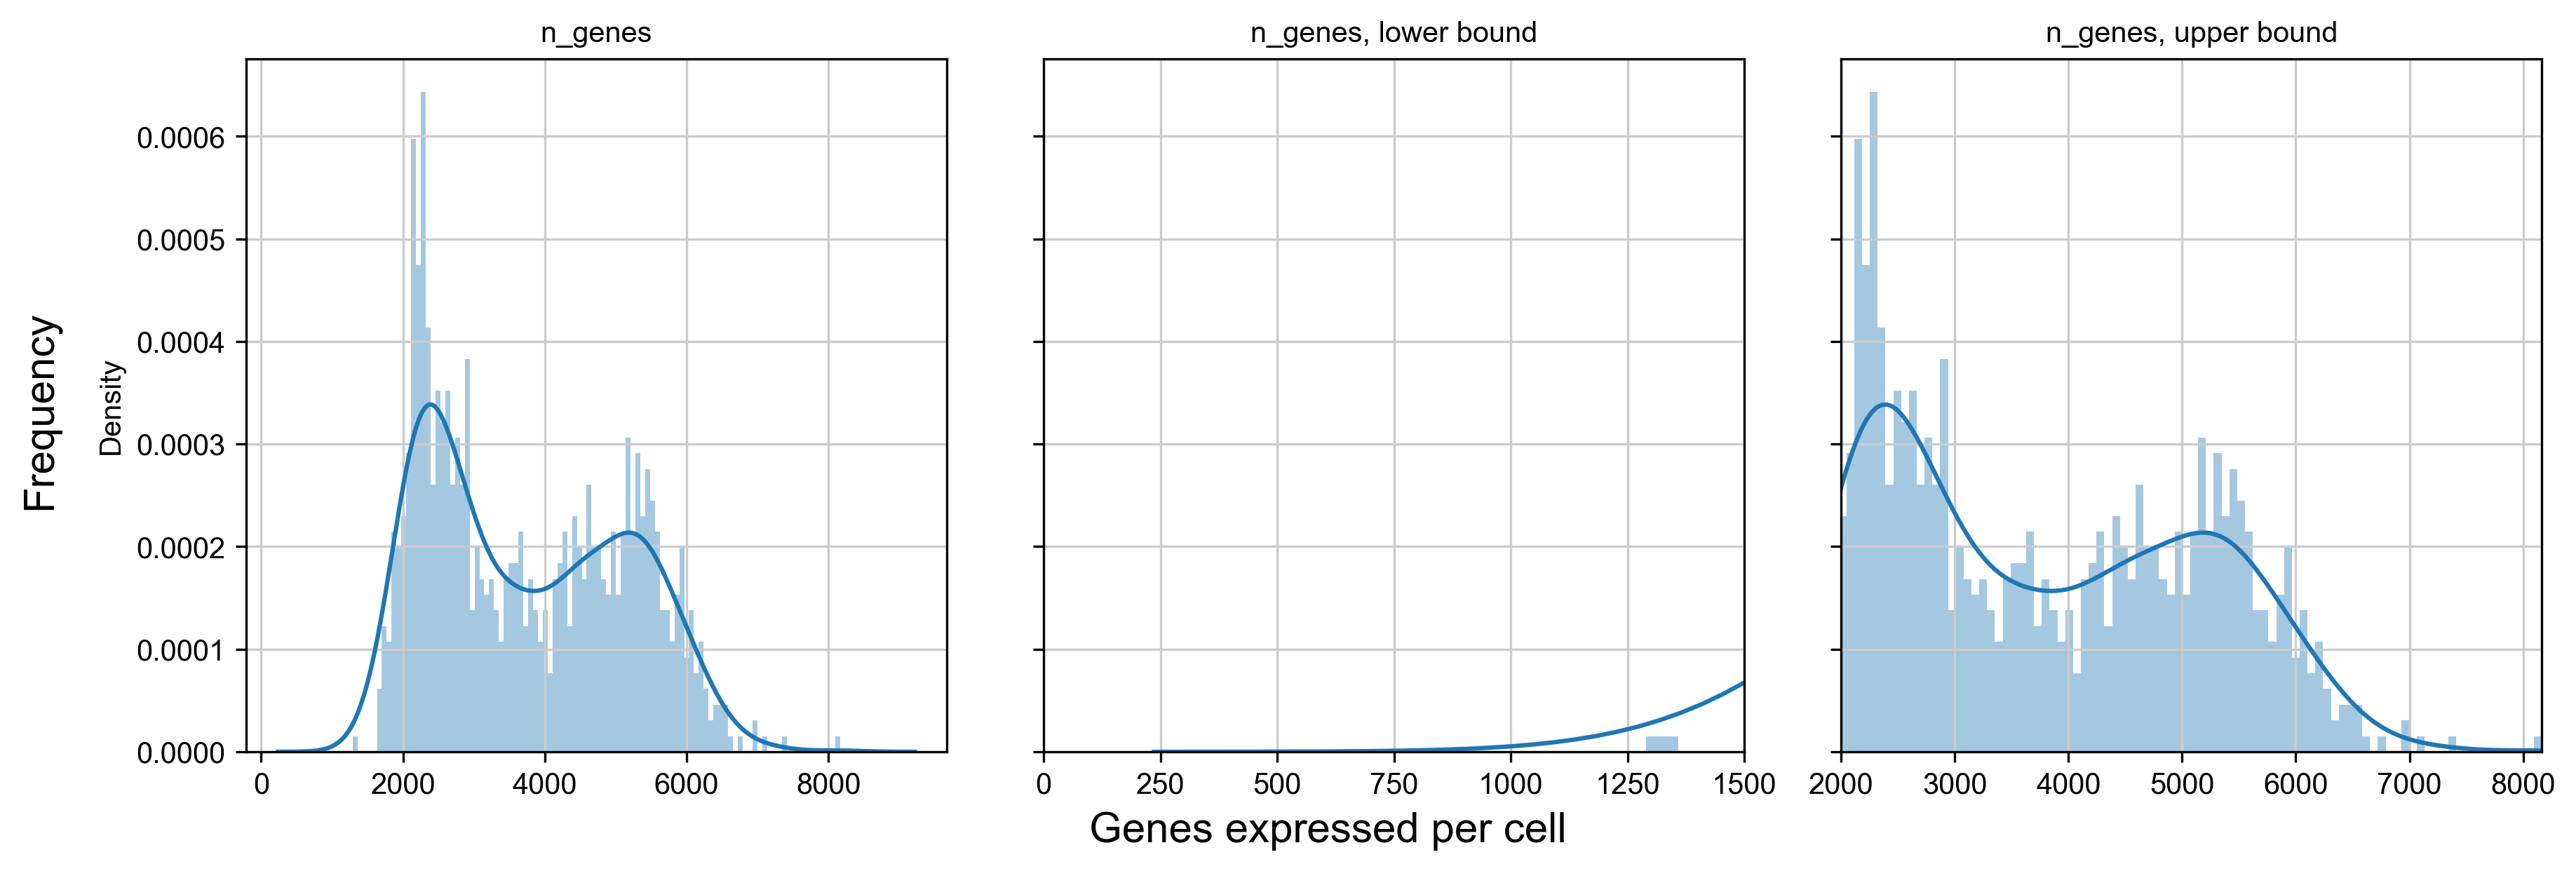

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['n_genes']
x_lowerbound = 1500
x_upperbound = 2000
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax3, norm_hist=True, bins=nbins)

ax2.set_xlim(0,x_lowerbound)
ax3.set_xlim(x_upperbound, adata.obs['n_genes'].max() )

for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('n_genes')
ax2.title.set_text('n_genes, lower bound')
ax3.title.set_text('n_genes, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Genes expressed per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

In [15]:
adata.obs

,nGene,nUMI,n_genes,n_counts
AAACGCTGTGTACATC-1,4137,12357.0,4137,12357.0
AAACGCTTCCAGTGTA-1,5973,36742.0,5973,36742.0
AAAGGATGTTTACGTG-1,4903,25468.0,4903,25468.0
AAAGGTATCAGGAAAT-1,2152,4422.0,2152,4422.0
AAAGTCCAGCTCGAAG-1,1290,4371.0,1290,4371.0
...,...,...,...,...
TTTGATCCACGTAGTT-1,1962,5835.0,1962,5835.0
TTTGATCGTGTTGACT-1,1763,4579.0,1763,4579.0
TTTGATCTCAGGAGAC-1,2346,4841.0,2346,4841.0
TTTGGAGAGCTGCCTG-1,1965,4249.0,1965,4249.0
